## Cellstitch test 

In [1]:
import torch

vram = torch.cuda.mem_get_info()[0] / 1024  # In KB

In [14]:
from skimage.io import imread
import os
import numpy as np
from tnia.plotting.projections import show_xy_zy_max, show_xy_zy_slice_center
from tnia.plotting.plt_helper import imshow_multi2d, random_label_cmap
from tnia.plotting.projections import show_xy_zy_max
from tnia.plotting.plt_helper import create_rgb, imshow_multi2d, create_linear_napari_color_map, get_color


In [12]:
### Use skimage cells data

from skimage.data import cells3d

im = cells3d()
print(f'image_3D.shape: {im.shape}')

# move channels last
#im = np.moveaxis(im, 1, -1)

print(f'image_3D.shape: {im.shape}')


image_3D.shape: (60, 2, 256, 256)
image_3D.shape: (60, 2, 256, 256)


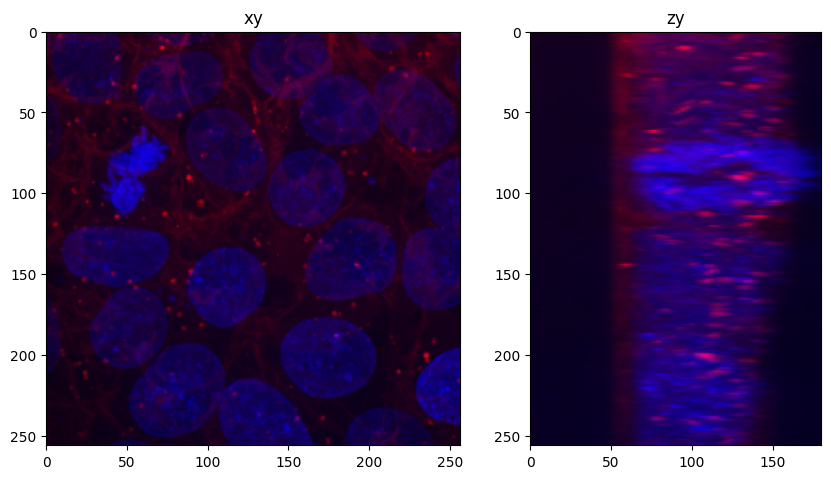

In [4]:
rgb = create_rgb(im)
fig = show_xy_zy_max(rgb,sz=3,figsize=(10,10))

In [7]:

im_ = np.transpose(im, (0, 3, 1, 2))


In [13]:
help(cellstitch_cuda)

Help on function cellstitch_cuda in module cellstitch_cuda.pipeline:

cellstitch_cuda(img, output_masks: bool = False, output_path=None, stitch_method: str = 'cellstitch', seg_mode: str = 'nuclei_cells', normalise: bool = True, pixel_size=None, z_step=None, bleach_correct: bool = True, filtering: bool = True, n_jobs: int = -1, verbose: bool = False)
    All-in-one function to segment and stitch 2D labels
    
    Full stitching pipeline, which does the following:
        1. Histogram-based signal degradation correction
        2. Segmentation over the Z axis using InstanSeg
        3. Stitching of 2D planes into 3D labels, by one of two methods:
            a. Cellpose's standard Intersect over Union (IoU) calculation
            b. CellStitch's orthogonal labeling, which leverages Optimal Transport to create robust masks.
    
    Args:
        img: Either a path pointing to an existing image, or a numpy.ndarray. Must be 4D (ZCYX).
        output_masks: True to write all masks to the 

In [20]:
im.shape, im_.shape

((60, 2, 256, 256), (60, 2, 256, 256))

CUDA is available. Using device 0
Model fluorescence_nuclei_and_cells downloaded and extracted to /home/bnorthan/mambaforge/envs/cellstitch-cuda/lib/python3.11/site-packages/instanseg/utils/../bioimageio_models/
Requesting default device: cuda
CUDA is available. Using device 0
Model fluorescence_nuclei_and_cells downloaded and extracted to /home/bnorthan/mambaforge/envs/cellstitch-cuda/lib/python3.11/site-packages/instanseg/utils/../bioimageio_models/
Requesting default device: cuda


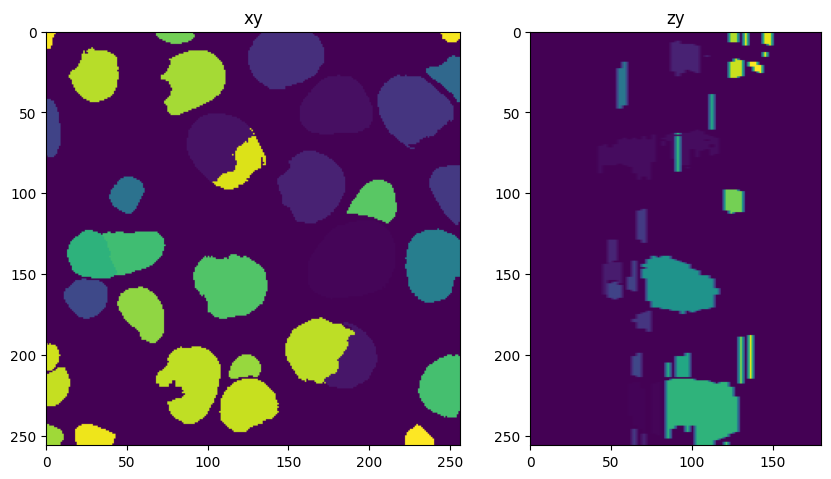

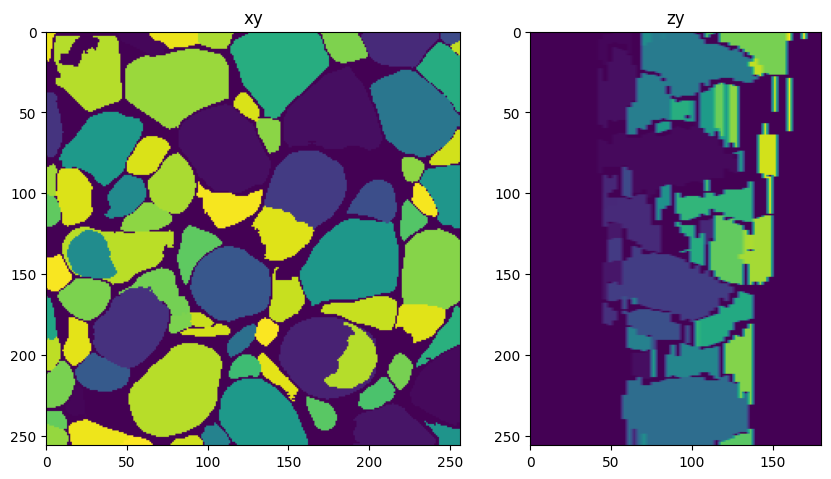

In [21]:
from cellstitch_cuda.pipeline import cellstitch_cuda


nuclei = cellstitch_cuda(im, seg_mode="nuclei", pixel_size=.26, z_step=.3)
cells = cellstitch_cuda(im, seg_mode="cells", pixel_size=.26, z_step=.3)

fig = show_xy_zy_slice_center(nuclei,sz=3,figsize=(10,10))
fig = show_xy_zy_slice_center(cells,sz=3,figsize=(10,10))

In [17]:
import napari

viewer = napari.Viewer()
#viewer.add_image(im, name='cells')
viewer.add_image(im[:,0,:,:], name='cells ch0')
viewer.add_image(im[:,1,:,:], name='cells ch1')
viewer.add_labels(nuclei, name='nuclei')
viewer.add_labels(cells, name='cells')

<Labels layer 'cells' at 0x70e133b2eed0>

In [5]:
import napari 
viewer = napari.Viewer()

for i in range(im.shape[-1]):
    color = get_color(i)
    new_colormap = create_linear_napari_color_map(str(i), color)
    viewer.add_image(im[...,i], name='im', colormap=new_colormap, blending='additive')
    #viewr.add_image(im, name='im')

In [8]:
from cellpose import models, io
import logging
#logging.basicConfig(level=logging.DEBUG)
mod = models.Cellpose(gpu=True, model_type="cyto3")

/home/bnorthan/mambaforge/envs/cellstitch-cuda/lib/python3.11/site-packages/cellpose/resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

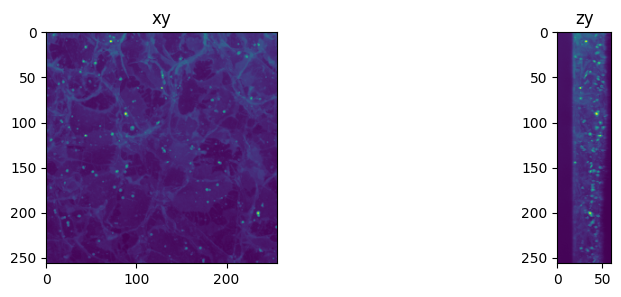

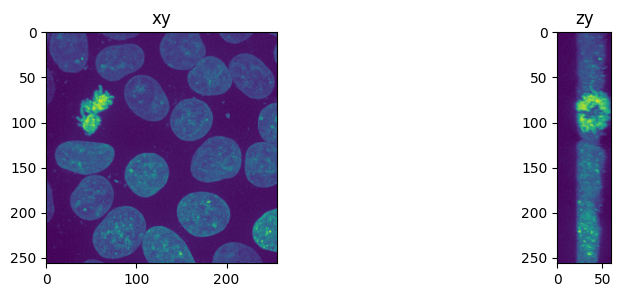

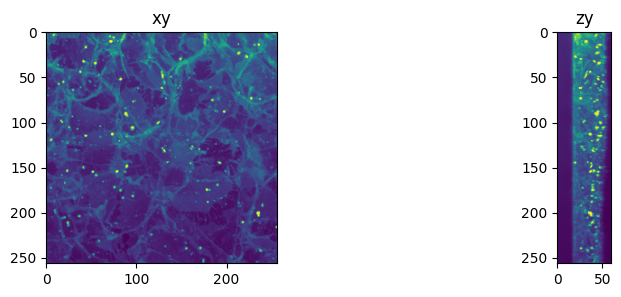

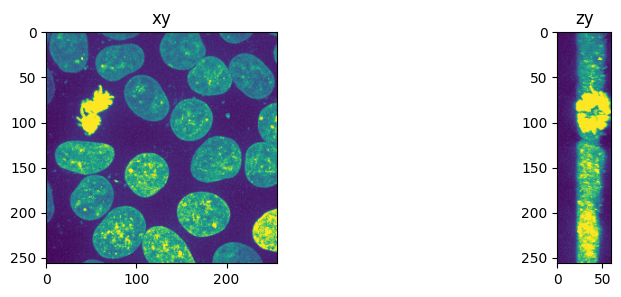

In [9]:
from tnia.deeplearning.dl_helper import quantile_normalization, get_label_paths

normalized = quantile_normalization(im, quantile_low=0.001, quantile_high=0.999)

fig = show_xy_zy_max(im[...,0])
fig = show_xy_zy_max(im[...,1])

fig = show_xy_zy_max(normalized[...,0])
fig = show_xy_zy_max(normalized[...,1])

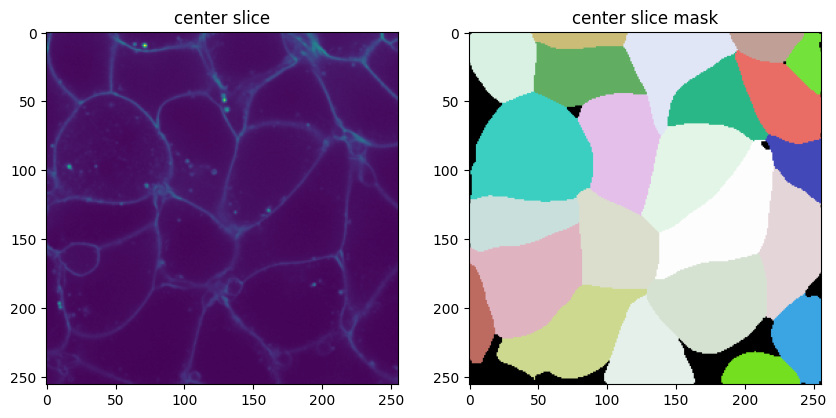

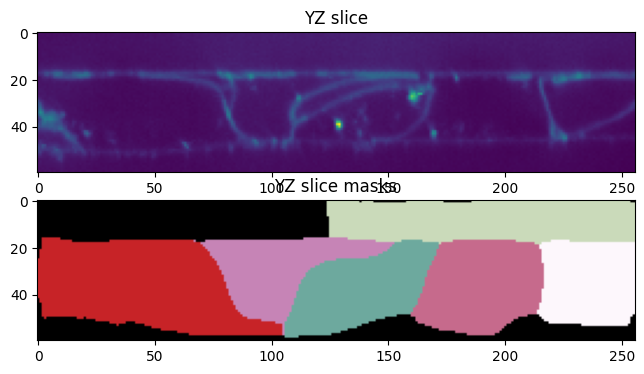

In [10]:
# get center slice 
z_slice_num = im.shape[0]//2
diameter = 60

center_slice = im[z_slice_num,:,...]
YZ_slice = im[:,im.shape[1]//2,...]

center_slice_masks = mod.eval(center_slice, diameter=diameter, channels=[0,1], cellprob_threshold=0)
YZ_slice_masks = mod.eval(YZ_slice, diameter=diameter, channels=[0,1], cellprob_threshold=0)

fig = imshow_multi2d([center_slice[...,0], center_slice_masks[0]], ['center slice', 'center slice mask'], 1, 2, height=15, colormaps=[None, random_label_cmap()])

fig = imshow_multi2d([YZ_slice[...,0], YZ_slice_masks[0]], ['YZ slice', 'YZ slice masks'], 2, 1, colormaps=[None, random_label_cmap()])  

In [11]:
viewer = napari.Viewer()

viewer.add_image(center_slice[...,1], name='center_slice')
viewer.add_labels(center_slice_masks[0], name='center_slice_masks')

<Labels layer 'center_slice_masks' at 0x78b94e5e5910>

In [12]:
mask3D = mod.eval(im, diameter=50, channels=[1,2], anisotropy=3,  do_3D=True, niter=200, channel_axis=3, dP_smooth=5)[0]

In [10]:
import napari

viewer = napari.Viewer()

viewer.add_image(im[...,0], name='ch0')
viewer.add_image(im[...,1], name='ch1')
#viewer.add_image(normalized, name='normalized')
viewer.add_labels(np.array(mask3D), name='mask3D')

<Labels layer 'mask3D' at 0x75a468368860>